### Predict power output given a set of environmental readings from various sensors in a natural gas-fired power generation plant

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.  
A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another. While the Vacuum is colected from and has effect on the Steam Turbine, he other three of the ambient variables effect the GT performance.

Features consist of hourly average ambient variables 
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in teh range 25.36-81.56 cm Hg
- Net hourly electrical energy output (EP) 420.26-495.76 MW
The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

### Modelling steps
1. Library imports
2. Dataset understanding
3. Variable relationships

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_excel('Data/Folds5x2_pp.xlsx')

In [4]:
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [6]:
df.shape

(9568, 5)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
AT    9568 non-null float64
V     9568 non-null float64
AP    9568 non-null float64
RH    9568 non-null float64
PE    9568 non-null float64
dtypes: float64(5)
memory usage: 373.8 KB


In [5]:
df.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


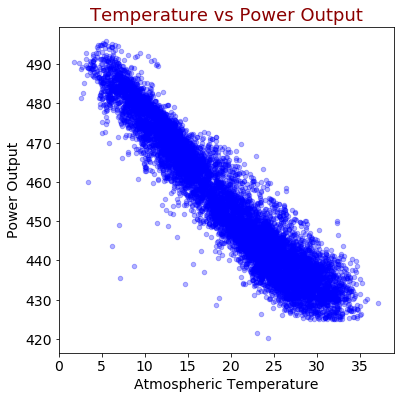

In [24]:
df.plot(x ='AT', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Temperature vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Atmospheric Temperature", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

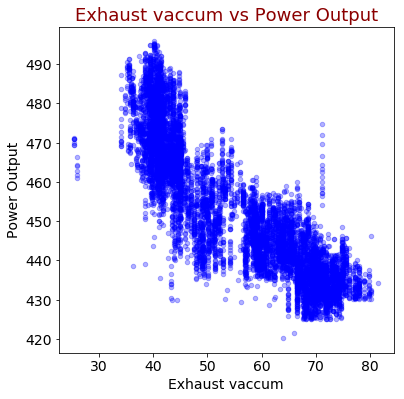

In [26]:
df.plot(x ='V', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Exhaust vaccum vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Exhaust vaccum", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

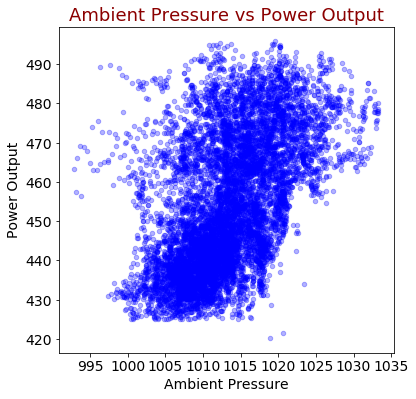

In [28]:
df.plot(x ='AP', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Ambient Pressure vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Ambient Pressure", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

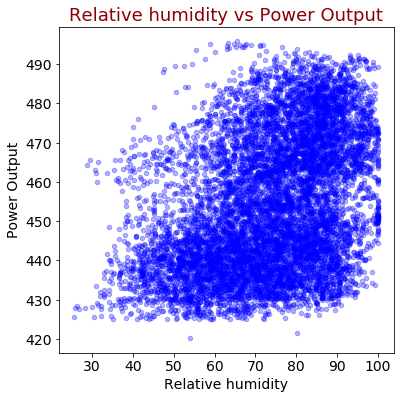

In [29]:
df.plot(x ='RH', y = 'PE', kind ="scatter", 
                 figsize = [6,6],
                 color ="b", alpha = 0.3, 
                fontsize = 14)
plt.title("Relative humidity vs Power Output", 
          fontsize = 18, color="darkred")
plt.xlabel("Relative humidity", fontsize = 14) 
plt.ylabel("Power Output", fontsize = 14)
plt.show()

In [35]:
corelation_mat = df.corr()
corelation_mat

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


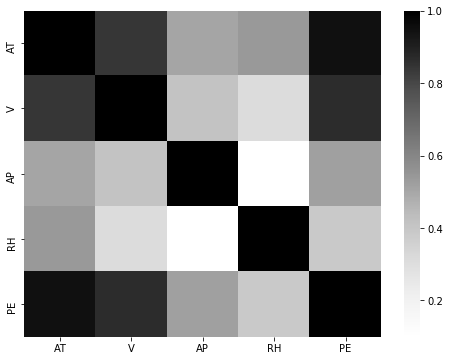

In [36]:
corelation_mat = corelation_mat.abs()
plt.figure(figsize = (8, 6))
sns.heatmap(corelation_mat, cmap="Greys",
            xticklabels=corelation_mat.columns.values,
            yticklabels=corelation_mat.columns.values)
plt.show()

High collinearity between variables and target  
But multicollinearity also present between variables